In [1]:
import numpy as np
from astropy import coordinates as coo
from astropy import units as u
import healpy as hp
import matplotlib.pyplot as plt
import multiprocessing as mp

In [2]:
Nside_jack = 3
def weight_nan_mean(value, weight):
    mean_val = np.zeros(value.shape[1])
    for i in range(len(mean_val)):
        idx = np.logical_not(np.isnan(value[:,i]))
        val = value[idx,i]
        wei = weight[idx,i]
        mean_val[i] = np.average(val, weights=wei)
    return mean_val

In [4]:
def load_data(file):
    if type(file) == str:
        file = open(file, 'rb')
    datas = []
    while True:
        try:
            datas.append(np.load(file))
        except EOFError:
            file.close()
            break
    return datas

def load_calculation_data(file):
    global r_p
    dat = load_data(file)
    if len(dat) == 1:
        return dat[0]
    elif len(dat) == 2:
        r_p = dat[0]
        return dat[1]

In [5]:
dat = load_calculation_data('../calculation_data/result_r=0.1_150_16_cmass_z_cut_CMB_lcut_tree.npy')
dat_r = load_calculation_data('../calculation_data/result_r=0.1_150_16_random_cmass_CMB_lcut_tree.npy')
value = dat[0]
weight = dat[1]
value_r = dat_r[0]
weight_r = dat_r[1]
cmass = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/catalogue/cmass_z_cut.npy')
Nquas = len(cmass)
c = coo.SkyCoord(ra=cmass['ra']*u.degree, dec=cmass['dec']*u.degree)

l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pos = hp.ang2vec(theta=np.pi/2-b, phi=l)
pix = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading cmass catalogue')

random = np.load('/uufs/astro.utah.edu/common/home/u6060319/quasar-CMBlening/catalogue/random_cmass.npy')
Nquas = len(random)
c = coo.SkyCoord(ra=random['ra']*u.degree, dec=random['dec']*u.degree)
l = c.galactic.l.to(u.rad).value
b = c.galactic.b.to(u.rad).value
pix_r = hp.ang2pix(Nside_jack, theta=np.pi/2-b, phi=l)

print('finish loading random sample')

finish loading cmass catalogue
finish loading random sample


## cmass sample

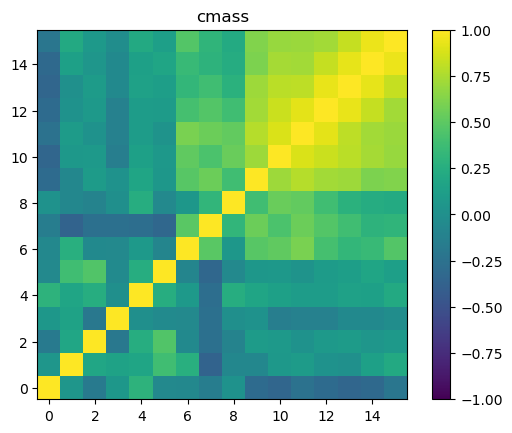

In [6]:
mean = weight_nan_mean(value, weight)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value[idx], weight[idx])
pro = mp.Pool(20)
jack_val_q = np.vstack(pro.map(jackknife_resample_q, np.unique(pix)))
cov_mat = np.cov(jack_val_q, ddof=1, rowvar=False)
std = np.std(jack_val_q, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std[i]*std[j]
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.colorbar()
plt.title('cmass')
plt.show()

## random sample

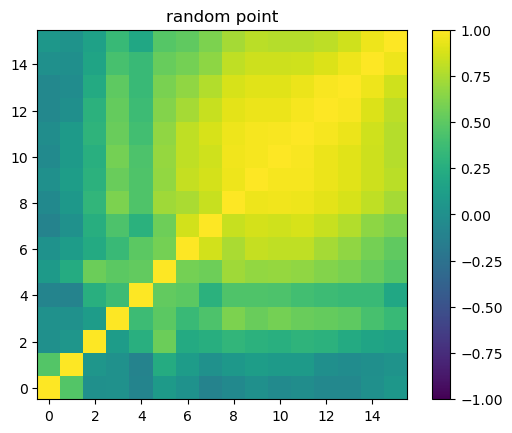

In [7]:
mean_r = weight_nan_mean(value_r, weight_r)
def jackknife_resample_r(i):
    idx = pix_r != i
    return weight_nan_mean(value_r[idx], weight_r[idx])
pro = mp.Pool(20)
result = pro.map(jackknife_resample_r, np.unique(pix_r))
jack_val_r = np.vstack(result)
cov_mat = np.cov(jack_val_r, ddof=1, rowvar=False)
std_r = np.std(jack_val_r, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_r[i]*std_r[j]
plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('random point')
plt.colorbar()
plt.show()

## cmass - random

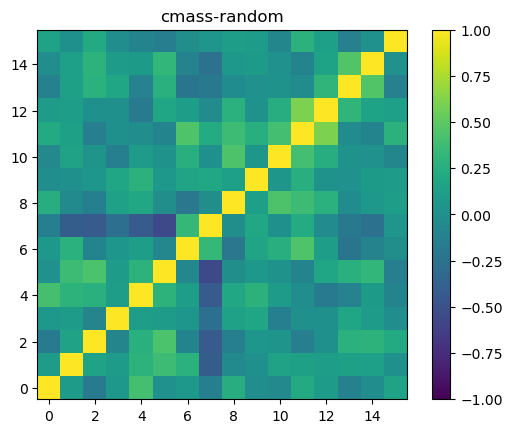

In [8]:
def jackknife_resample(i):
    idx = pix != i
    idx_r = pix_r != i
    return weight_nan_mean(value[idx], weight[idx])-weight_nan_mean(value_r[idx_r], weight_r[idx_r])
pro = mp.Pool(20)
result = pro.map(jackknife_resample, np.unique(pix))
jack_val = np.vstack(result)
cov_mat = np.cov(jack_val, ddof=1, rowvar=False)
std_sub = np.std(jack_val, axis=0, ddof=1)
for i in range(cov_mat.shape[0]):
    for j in range(cov_mat.shape[0]):
        cov_mat[i,j] /= std_sub[i]*std_sub[j]

plt.imshow(cov_mat, origin='lower', vmin=-1, vmax=1)
plt.title('cmass-random')
plt.colorbar()
plt.show()

(0.0001, 51.746484894667624)

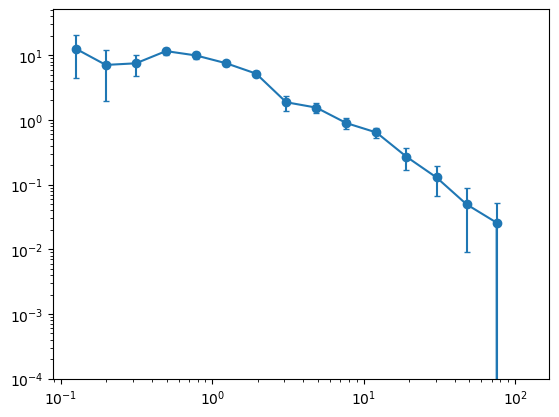

In [11]:
sig = mean-mean_r
plt.errorbar(r_p, sig, std_sub*np.sqrt(len(np.unique(pix))), capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.loglog()
plt.ylim(bottom=1e-4)

## signal

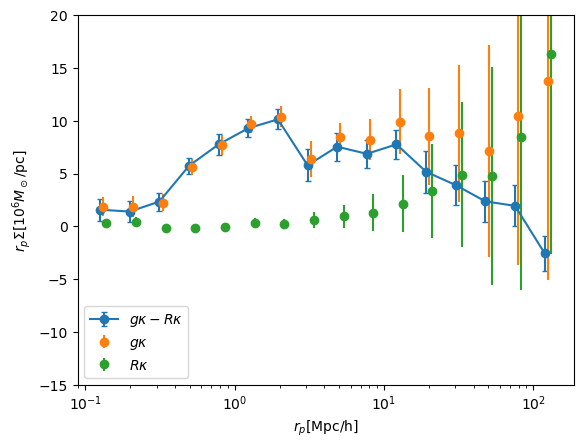

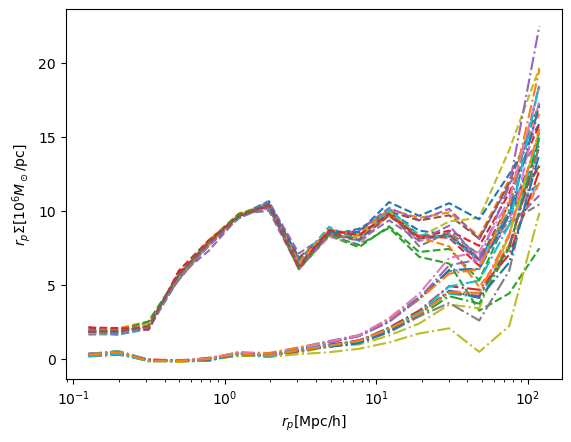

In [9]:
sig = mean-mean_r
plt.errorbar(r_p, r_p*sig, r_p*std_sub*np.sqrt(len(np.unique(pix))), capsize=2, fmt='-o', label='$g\\kappa-R\\kappa$')
plt.errorbar(r_p*1.05, r_p*mean, r_p*std*np.sqrt(len(np.unique(pix))), label='$g\\kappa$', fmt='o')
plt.errorbar(r_p*1.05*1.05, r_p*mean_r, r_p*std_r*np.sqrt(len(np.unique(pix_r))), label='$R\\kappa$', fmt='o')
plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
plt.ylim(-15, 20)
plt.legend(loc='lower left')
plt.savefig('./fig/cmass_random_l_cut.jpg')
plt.show()

for i in range(jack_val_q.shape[1]):
    plt.plot(r_p, r_p*jack_val_q[i], '--')
for i in range(jack_val_r.shape[1]):
    plt.plot(r_p, r_p*jack_val_r[i], '-.')

plt.semilogx()
plt.xlabel('$r_p[\\mathrm{Mpc/h}]$')
plt.ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')

plt.savefig('./fig/cmass_random_jack_l_cut.jpg')
plt.show()


In [8]:
dat_2 = np.load('../calculation_data/result_r=0.5_100_15_cmass_cut_400.npy')
value_2 = dat_2[0]
weight_2 = dat_2[1]
mean_2 = weight_nan_mean(value_2, weight_2)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value_2[idx], weight_2[idx])
pro = mp.Pool(20)
jack_val_q = np.vstack(pro.map(jackknife_resample_q, np.unique(pix)))
cov_mat = np.cov(jack_val_q, ddof=1, rowvar=False)
std_2 = np.std(jack_val_q, axis=0, ddof=1)

In [9]:
dat_3 = np.load('../calculation_data/result_r=0.5_100_15_cmass_cut_4096.npy')
value_3 = dat_3[0]
weight_3 = dat_3[1]

mean_3 = weight_nan_mean(value_3, weight_3)
def jackknife_resample_q(i):
    idx = pix != i
    return weight_nan_mean(value_3[idx], weight_3[idx])
pro = mp.Pool(20)
jack_val_q = np.vstack(pro.map(jackknife_resample_q, np.unique(pix)))
cov_mat = np.cov(jack_val_q, ddof=1, rowvar=False)
std_3 = np.std(jack_val_q, axis=0, ddof=1)

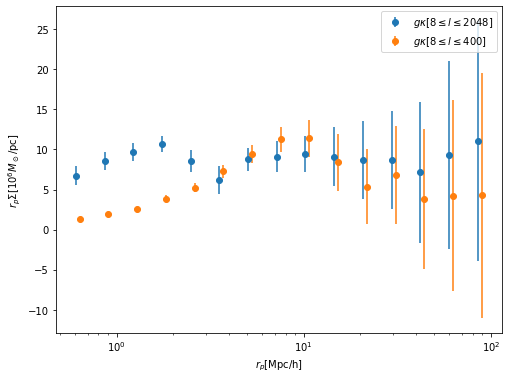

In [13]:
r_bins = np.geomspace(0.5, 100, 15+1)        # unit: cMpc/h
r_p = (r_bins[1:]+r_bins[:-1])/2
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(r_p, r_p*mean, r_p*std*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 2048]$', fmt='o')
ax.errorbar(r_p*1.05, r_p*mean_2, r_p*std_2*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 400]$', fmt='o')
# plt.errorbar(r*1.05*1.05, r*mean_3, r*std_3*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 4096]$', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=100, bottom=-100)
ax.legend()
plt.savefig('./fig/cmass_l_cut_comp.jpg')
plt.show()

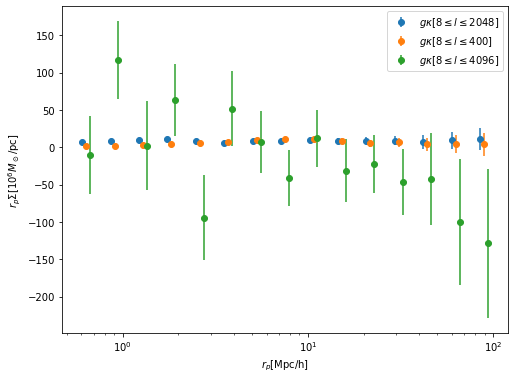

In [12]:
r_bins = np.geomspace(0.5, 100, 15+1)        # unit: cMpc/h
r_p = (r_bins[1:]+r_bins[:-1])/2
fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(r_p, r_p*mean, r_p*std*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 2048]$', fmt='o')
ax.errorbar(r_p*1.05, r_p*mean_2, r_p*std_2*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 400]$', fmt='o')
plt.errorbar(r_p*1.05*1.05, r_p*mean_3, r_p*std_3*np.sqrt(len(np.unique(pix))), label='$g\\kappa[8\\leq l\\leq 4096]$', fmt='o')
ax.semilogx()
ax.set_xlabel('$r_p[\\mathrm{Mpc/h}]$')
ax.set_ylabel('$r_p\\Sigma[10^6 M_\\odot/\\mathrm{pc}]$')
# plt.ylim(top=30, bottom=-30)
ax.legend()
plt.savefig('./fig/cmass_l_cut_comp_2.jpg')
plt.show()